In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dense
from keras.callbacks import *
from keras.optimizers import Adam
from statistics import mean
import os
from numpy import array
import tensorflow as tf

Using TensorFlow backend.


In [2]:
tesla = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/TSLA.csv', header=0, index_col=0)
print(tesla)
ftse = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/FTSE100.csv', header=0, index_col=0)
dow =  pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/Dow Jones US AUTO STOCK INDEX-5 Years.csv', header=0, index_col=0)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2015-05-15  243.929993  249.399994  242.500000  248.839996  248.839996   
2015-05-18  247.000000  249.899994  246.000000  248.750000  248.750000   
2015-05-19  248.429993  251.000000  246.149994  247.139999  247.139999   
2015-05-20  247.130005  247.740005  241.369995  244.350006  244.350006   
2015-05-21  243.029999  246.619995  242.360001  245.619995  245.619995   
...                ...         ...         ...         ...         ...   
2020-05-08  793.770020  824.000000  787.010010  819.419983  819.419983   
2020-05-11  790.510010  824.000000  785.000000  811.289978  811.289978   
2020-05-12  827.000000  843.289978  808.000000  809.409973  809.409973   
2020-05-13  820.830017  826.000000  763.299988  790.960022  790.960022   
2020-05-14  780.000000  803.359985  764.000000  803.330017  803.330017   

              Volume  
Date          

In [3]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close
    
df = tesla
dataframe_tsla = df
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

tesla

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-05-15,0.130072,0.116005,0.133492,0.135922,0.135922,0.063416
2015-05-18,0.134002,0.116619,0.138098,0.135806,0.135806,0.043918
2015-05-19,0.135833,0.117970,0.138295,0.133725,0.133725,0.049247
2015-05-20,0.134169,0.113965,0.132005,0.130120,0.130120,0.050599
2015-05-21,0.128920,0.112589,0.133308,0.131761,0.131761,0.020963
...,...,...,...,...,...,...
2020-05-08,0.833931,0.821884,0.849981,0.873344,0.873344,0.256050
2020-05-11,0.829758,0.821884,0.847336,0.862837,0.862837,0.261712
2020-05-12,0.876469,0.845581,0.877600,0.860407,0.860407,0.252344


In [4]:
def build_data(start,pw,window_size=200):
    
    X_train,X_test = Xarr[start:start+window_size],Xarr[start+window_size:start+window_size+pw]
    y_train,y_test = yarr[start:start+window_size],yarr[start+window_size:start+window_size+pw]
    Date_train,Date_test = Datearr[start:start+window_size],Datearr[start+window_size:start+window_size+pw]
    return X_train,X_test,y_train,y_test,Date_train,Date_test

trn_size = len(Xarr)
#print(build_data(0,1,200))

In [6]:
import time
%matplotlib inline

file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]

Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(6, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(40, activation='relu'))
model.add(Dense(3))
model.compile(optimizer='adam', loss="mean_absolute_error")
    
from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,5):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat)
            actual_high.append(y_test)
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
print(val_loss)

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
starting sample: 4 ...
completed sample: 4 ...
time taken for execution : 503.7768340110779 seconds 
Mean Validation loss= 0.00920017
[0.00916419, 0.00938488, 0.0091414, 0.00917529, 0.00913509]


0.009200169999999999


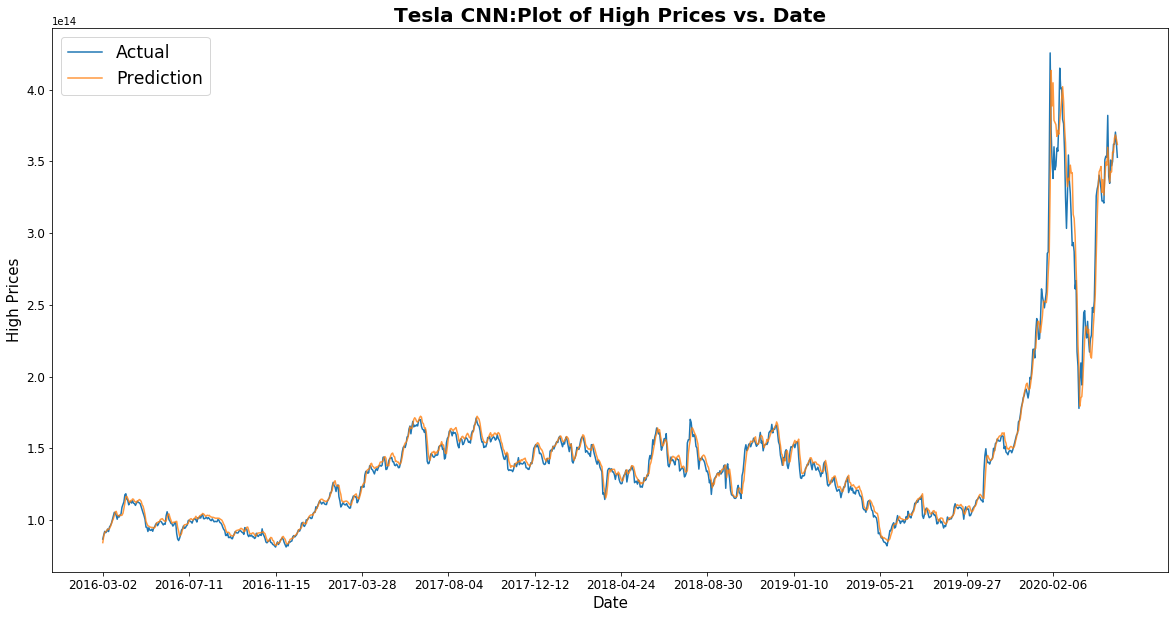

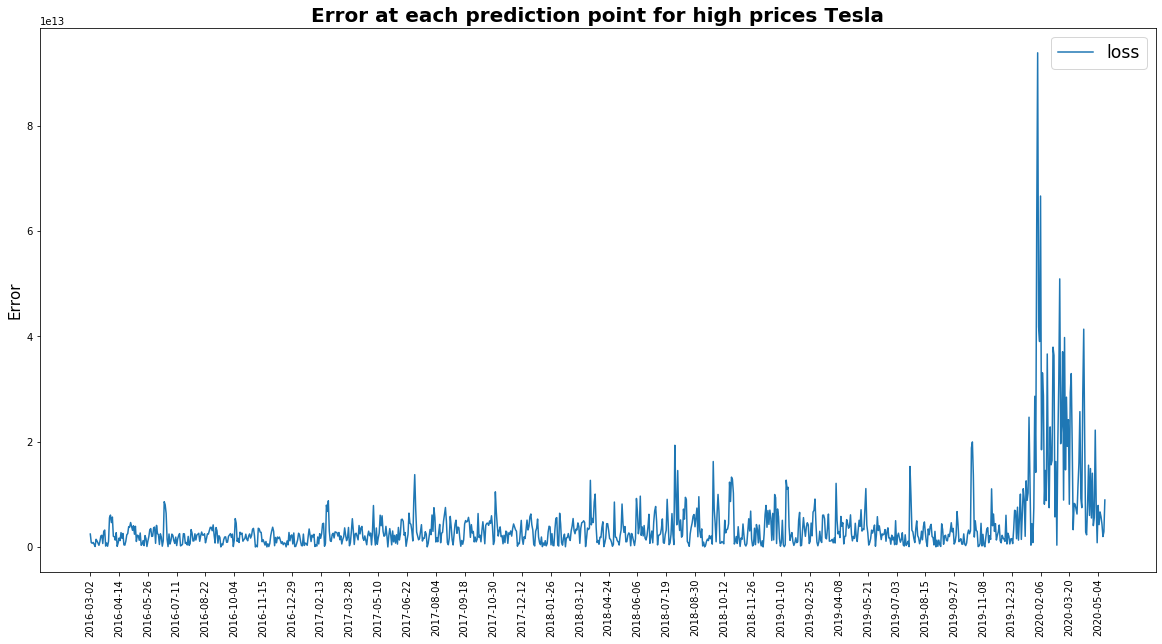

In [11]:
actual_out = np.empty([len(actual_high), 3])
predicted_out = np.empty([len(actual_high), 3])
for i in range(0,len(actual_high)):
    actual_out[i]= actual_high[i]
    predicted_out[i] = predicted_high[i]
print(mean(val_loss))

def evaluate_model(actual,predicted,dates,title_str,y_label):

    plt.figure(figsize=(20,10))
    plt.title(title_str,fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel(y_label,fontsize=15)
    plt.plot((actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")


def mae(y_predicted,y_actual,dates,title_str):
    n = len(y_predicted)
    loss = []
    for i in range(0,n):
        loss.append(abs(y_predicted[i] - y_actual[i]))
    index = np.arange((len(loss)),step=30)
    
    plt.figure(figsize=(20,10))
    plt.title(title_str,fontsize=20,fontweight='bold')
    plt.ylabel('Error',fontsize=15)
    plt.xticks(index,dates[index],rotation=90)
    plt.plot((np.array(loss).reshape(-1,1)), label="loss")
    plt.legend(fontsize="xx-large")
 
#Rescaling the high values from range 0-1 to original values:
actual_high= scaler_high.inverse_transform(np.array(actual_out[:,0]).reshape(-1,1))
predicted_high = scaler_high.inverse_transform(np.array(predicted_out[:,0]).reshape(-1,1))

actual_low= scaler_low.inverse_transform(np.array(actual_out[:,1]).reshape(-1,1))
predicted_low = scaler_low.inverse_transform(np.array(predicted_out[:,1]).reshape(-1,1))

actual_close= scaler_close.inverse_transform(np.array(actual_out[:,2]).reshape(-1,1))
predicted_close = scaler_close.inverse_transform(np.array(predicted_out[:,2]).reshape(-1,1))
title_str = 'Tesla CNN:Plot of High Prices vs. Date'
y_label = 'High Prices'
evaluate_model(actual_high,predicted_high ,np.array(predicted_dates),title_str,y_label )
#actual_low,predicted_low,actual_close,predicted_close)

title_str ='Error at each prediction point for high prices Tesla'
mae(predicted_high,actual_high,np.array(predicted_dates),title_str)


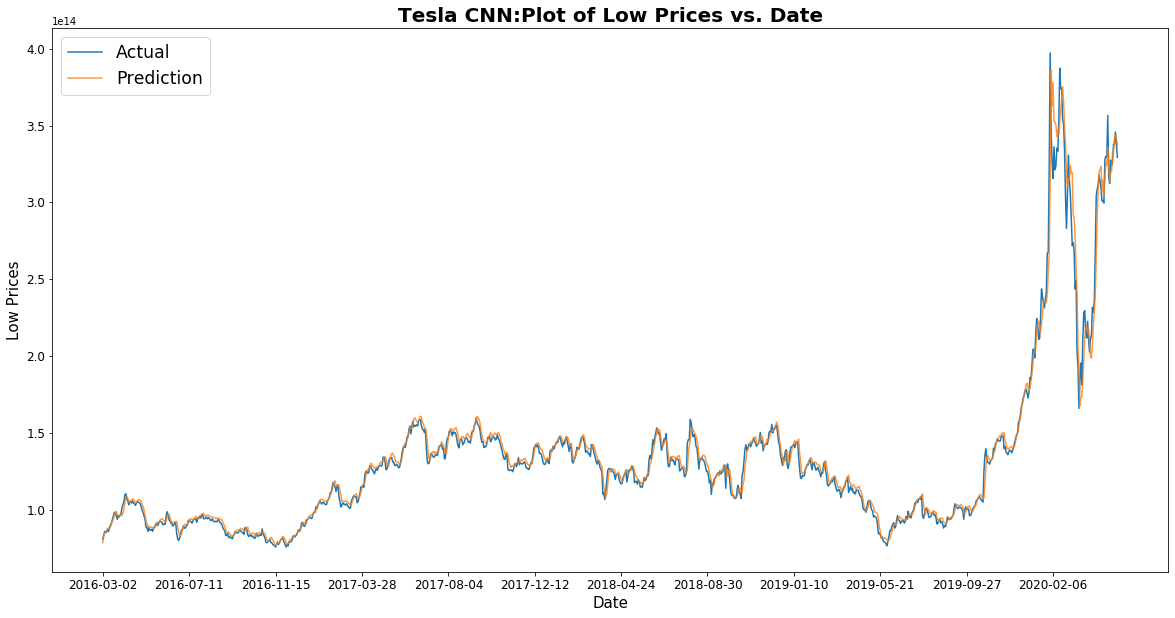

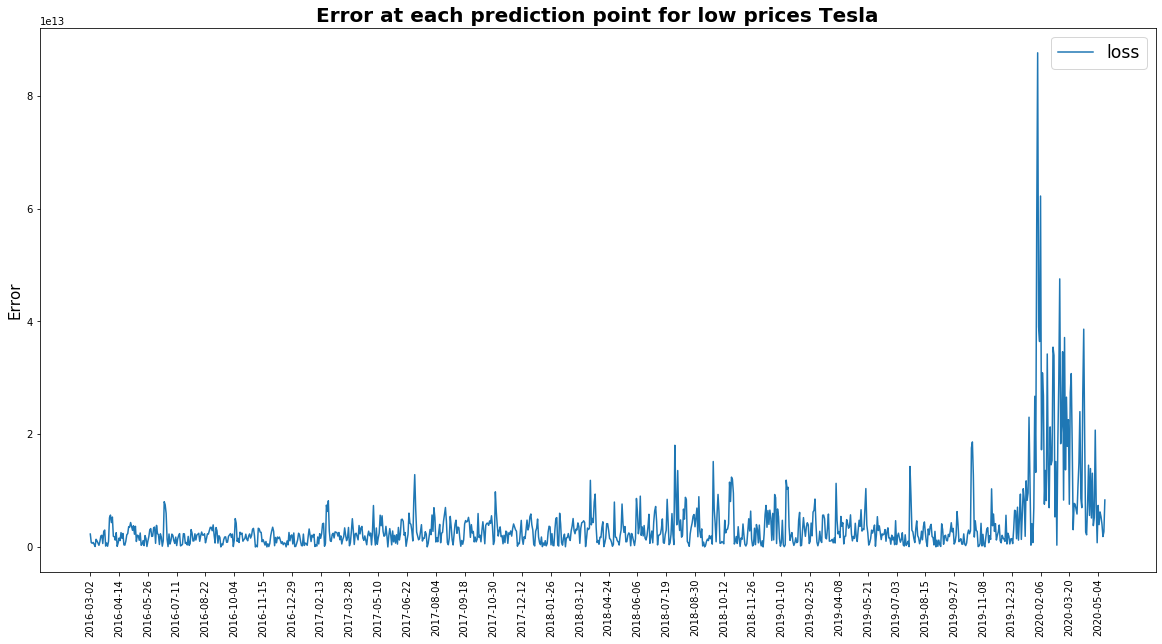

In [13]:
title_str = 'Tesla CNN:Plot of Low Prices vs. Date'
y_label = 'Low Prices'
evaluate_model(actual_low,predicted_low ,np.array(predicted_dates),title_str,y_label )
title_str ='Error at each prediction point for low prices Tesla'
mae(predicted_low,actual_low,np.array(predicted_dates),title_str)

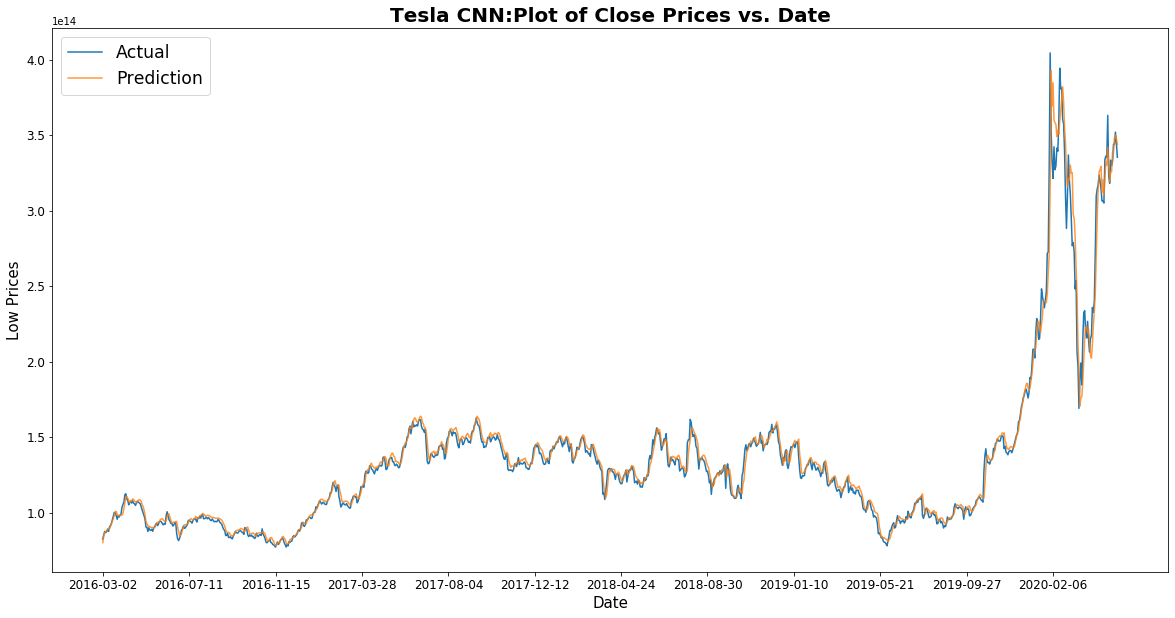

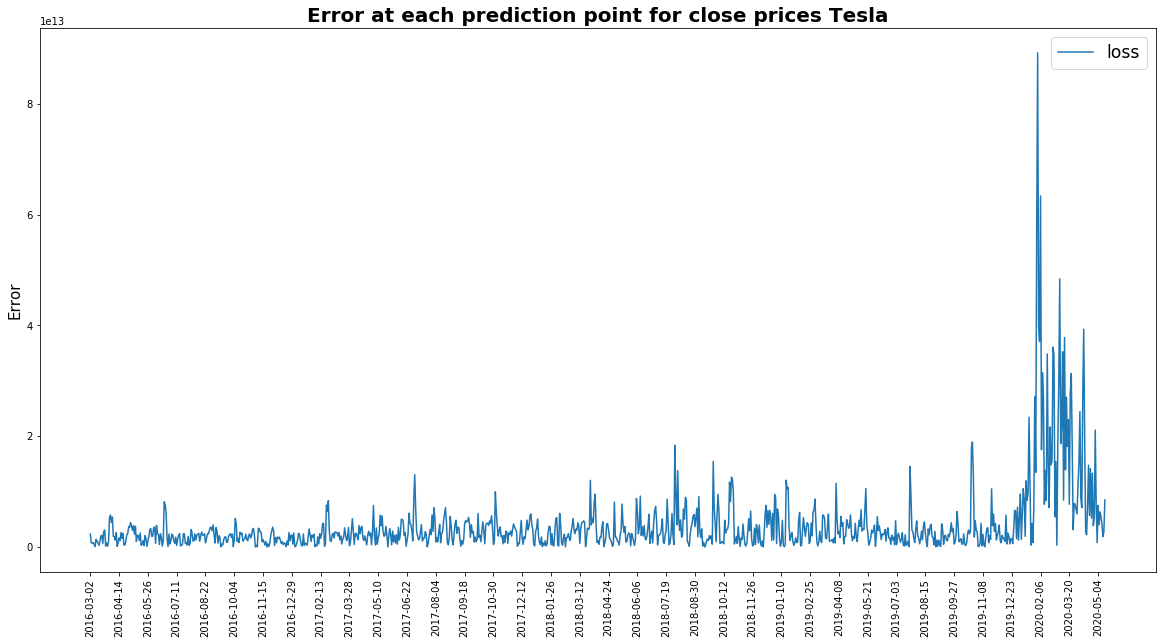

In [14]:
title_str = 'Tesla CNN:Plot of Close Prices vs. Date'
y_label = 'Low Prices'
evaluate_model(actual_close,predicted_close ,np.array(predicted_dates),title_str,y_label )
title_str ='Error at each prediction point for close prices Tesla'
mae(predicted_close,actual_close,np.array(predicted_dates),title_str)

<BarContainer object of 28 artists>

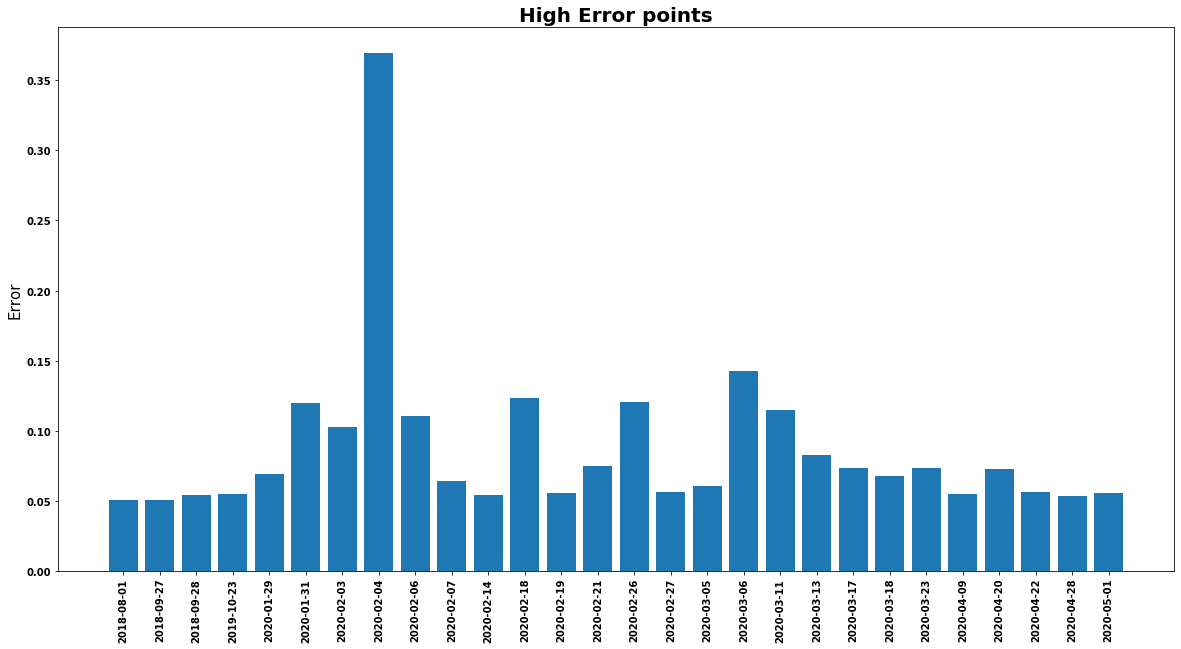

In [15]:

    large_loss = []
    large_loss_date = []
    for index in range(0,len(model_val_loss)):
        val_loss = model_val_loss[index]
        if val_loss>0.05:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
            large_loss.append(val_loss)
            large_loss_date.append(predicted_dates[index])


    plt.rcParams["font.weight"] = "bold"
    plt.figure(figsize=(20,10))
    plt.title('High Error points',fontsize=20,fontweight='bold')
    plt.ylabel('Error',fontsize=15)
    idx = np.arange(len(large_loss_date))
    plt.xticks(idx,large_loss_date,rotation=90)
    plt.bar(idx, large_loss, align='center', alpha=1)

# 2. Dow Jones Index:

In [18]:
#Convert Date Format:
tesla = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/TSLA.csv', header=0, index_col=0)
dow = pd.DataFrame(dow['Open'][3:1549])
tesla = tesla.drop(['Adj Close'], axis=1)
Month_dict={'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06',
       'Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
dates = []
dates = list(dow.index)
dates = dates[0:len(dates)]
newDates = []
for idx in range(0,len(dates)): 
    date = dates[idx]
    #print(date)
    day,month,year = date[4:6],Month_dict[date[0:3]],date[7:11]
    newDates.append(year+'-'+month+'-'+day)
dow.insert(1, "FormatDate", newDates)
dow

#merge values:
tesla_dates = list(tesla.index)
dow_dates = list(dow['FormatDate'])
mean_dow = mean(dow['Open'])
print(mean_dow,len(tesla_dates))
tesla["dow"] = mean_dow
for row_num in range(0,len(tesla_dates)):
    date = tesla_dates[row_num] 
    #print(date)
    if date in dow_dates:
        tesla["dow"][row_num] = mean((dow['Open'][dow['FormatDate']==date]))
    
tesla

198.13155194805194 1259


/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Volume,dow
Date,,,,,,
2015-05-15,243.929993,249.399994,242.500000,248.839996,4527600,209.910000
2015-05-18,247.000000,249.899994,246.000000,248.750000,3353200,212.630000
2015-05-19,248.429993,251.000000,246.149994,247.139999,3674200,213.620000
2015-05-20,247.130005,247.740005,241.369995,244.350006,3755600,213.010000
2015-05-21,243.029999,246.619995,242.360001,245.619995,1970600,211.420000
...,...,...,...,...,...,...
2020-05-08,793.770020,824.000000,787.010010,819.419983,16130100,198.131552
2020-05-11,790.510010,824.000000,785.000000,811.289978,16471100,198.131552
2020-05-12,827.000000,843.289978,808.000000,809.409973,15906900,198.131552


In [19]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_volume = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))

    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close

df = tesla
dataframe_tesla = df
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

In [20]:
import time
%matplotlib inline

file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]

Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(6, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(40, activation='relu'))
model.add(Dense(3))
model.compile(optimizer='adam', loss="mean_absolute_error")
    
from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,5):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat)
            actual_high.append(y_test)
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
print(val_loss)

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
starting sample: 4 ...
completed sample: 4 ...
time taken for execution : 505.8372039794922 seconds 
Mean Validation loss= 0.0098439
[0.0098134, 0.00975634, 0.00998198, 0.01002633, 0.00964146]


# 3. FTSE Index:

In [41]:
tesla = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/TSLA.csv', header=0, index_col=0)
tesla = tesla.drop(['Adj Close'], axis=1)
ftse = pd.DataFrame(ftse['Open'][18:1283])
Month_dict={'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06',
       'Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
dates = []
dates = list(ftse.index)
dates = dates[0:len(dates)]
newDates = []
for idx in range(0,len(dates)): 
    date = dates[idx]
    day,month,year = date[4:6],Month_dict[date[0:3]],date[8:12]
    newDates.append(year+'-'+month+'-'+day)
ftse.insert(1, "FormatDate", newDates)

#merge values:
tesla_dates = list(tesla.index)
ftse_dates = list(ftse['FormatDate'])
ftse["newOpen"] = 0
for row_num in range(0,len(ftse['Open'])):
    ftse["newOpen"][row_num] = float((ftse['Open'][row_num].replace(",", "")).replace("-", "0")) 
mean_ftse = mean(ftse["newOpen"])
tesla["ftse"] = mean_ftse
#print(ftse)
for row_num in range(0,len(tesla_dates)):
    date = tesla_dates[row_num] 
    #print(date,ftse['newOpen'][ftse['FormatDate']==date])
    if date in tesla_dates and len(ftse['newOpen'][ftse['FormatDate']==date])!=0 :
        #print(ftse['newOpen'][ftse['FormatDate']==date])
        tesla["ftse"][row_num] = mean(ftse['newOpen'][ftse['FormatDate']==date])
tesla

/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Volume,ftse
Date,,,,,,
2015-05-15,243.929993,249.399994,242.500000,248.839996,4527600,6973.000000
2015-05-18,247.000000,249.899994,246.000000,248.750000,3353200,6960.000000
2015-05-19,248.429993,251.000000,246.149994,247.139999,3674200,6968.000000
2015-05-20,247.130005,247.740005,241.369995,244.350006,3755600,6995.000000
2015-05-21,243.029999,246.619995,242.360001,245.619995,1970600,7007.000000
...,...,...,...,...,...,...
2020-05-08,793.770020,824.000000,787.010010,819.419983,16130100,6950.025414
2020-05-11,790.510010,824.000000,785.000000,811.289978,16471100,6950.025414
2020-05-12,827.000000,843.289978,808.000000,809.409973,15906900,6950.025414


In [42]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_ftse = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #ftse:
    fit = scaler_ftse.fit(np.array(data['ftse']).reshape(-1, 1))
    data['ftse'] =scaler_ftse.transform(np.array(data['ftse']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close

df = tesla
dataframe_tesla = df
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

In [43]:
import time
%matplotlib inline

file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]

Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(6, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(40, activation='relu'))
model.add(Dense(3))
model.compile(optimizer='adam', loss="mean_absolute_error")
    
from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,5):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat)
            actual_high.append(y_test)
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
print(val_loss)

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
starting sample: 4 ...
completed sample: 4 ...
time taken for execution : 531.6897351741791 seconds 
Mean Validation loss= 0.00974144
[0.01024625, 0.00949956, 0.01017136, 0.00960385, 0.0091862]


# 4. S&P Global Oil Index:

In [12]:
tesla = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/TSLA.csv', header=0, index_col=0)
tesla = tesla.drop(['Adj Close'], axis=1)
glb_oil = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/S&P Global Oil Index 5Y.csv', 
                      header=0, index_col=0)
# Date Conversion:
#Convert Date Format:yr-mnth-dt
dates = []
dates = list(glb_oil.index)
newDates = []
for idx in range(0,len(dates)): 
    date = dates[idx]
    day,month,year = date[0:2],date[3:5],'20'+date[6:8]
    newDates.append(year+'-'+month+'-'+day)
glb_oil.insert(1, "FormatDate", newDates)

#merge values:
tesla_dates = list(tesla.index)
oil_dates = list(glb_oil['FormatDate'])
mean_oil = mean(glb_oil['S&P Global Oil Index'])
tesla["oil"] = mean_oil
for row_num in range(0,len(tesla_dates)):
    date = tesla_dates[row_num] 
    #print(date)
    if date in oil_dates:
        tesla["oil"][row_num] = mean((glb_oil['S&P Global Oil Index'][glb_oil['FormatDate']==date]))
    
tesla

/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Volume,oil
Date,,,,,,
2015-05-15,243.929993,249.399994,242.500000,248.839996,4527600,1956.93
2015-05-18,247.000000,249.899994,246.000000,248.750000,3353200,1948.25
2015-05-19,248.429993,251.000000,246.149994,247.139999,3674200,1917.52
2015-05-20,247.130005,247.740005,241.369995,244.350006,3755600,1916.57
2015-05-21,243.029999,246.619995,242.360001,245.619995,1970600,1936.78
...,...,...,...,...,...,...
2020-05-08,793.770020,824.000000,787.010010,819.419983,16130100,1082.50
2020-05-11,790.510010,824.000000,785.000000,811.289978,16471100,1071.49
2020-05-12,827.000000,843.289978,808.000000,809.409973,15906900,1062.24


In [13]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_oil = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #S&P global Oil:
    fit = scaler_oil.fit(np.array(data['oil']).reshape(-1, 1))
    data['oil'] =scaler_oil.transform(np.array(data['oil']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close

df = tesla
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

In [14]:
import time
%matplotlib inline

file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]

Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(6, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(40, activation='relu'))
model.add(Dense(3))
model.compile(optimizer='adam', loss="mean_absolute_error")
    
from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,10):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat)
            actual_high.append(y_test)
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
print(val_loss)

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
starting sample: 4 ...
completed sample: 4 ...
starting sample: 5 ...
completed sample: 5 ...
starting sample: 6 ...
completed sample: 6 ...
starting sample: 7 ...
completed sample: 7 ...
starting sample: 8 ...
completed sample: 8 ...
starting sample: 9 ...
completed sample: 9 ...
time taken for execution : 1021.4047801494598 seconds 
Mean Validation loss= 0.00956445
[0.00988628, 0.00970755, 0.00998983, 0.00947981, 0.00937074, 0.00985184, 0.0094403, 0.00950325, 0.00913486, 0.00928003]


# 5. S&P1000 Index:

In [16]:
tesla = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/TSLA.csv', header=0, index_col=0)
sp1000 = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/S&P 1000.csv', 
                      header=0, index_col=0)
#Convert Date Format:
sp = []
sp = list(sp1000.index)
newdt = []
newsp = []

for idx in range(0,len(sp)): 
    spindex = sp[idx]
    year,month,day = '20'+spindex[6:],spindex[3:5],spindex[0:2]
    newdt.append(year+'-'+month+'-'+day)

sp1000.insert(1, "FormatDate", newdt)

#merge values:
tesla_dates = list(tesla.index)
sp1000_dates = list(sp1000['FormatDate'])
mean_sp = mean(sp1000['S&P 1000'])
#print(mean_sp,len(ford_dates))
tesla["S&P1000"] = mean_sp
for row_num in range(0,len(tesla_dates)):
    date = tesla_dates[row_num] 
    #print(date)
    if date in sp1000_dates:
        tesla["S&P1000"][row_num] = mean((sp1000['S&P 1000'][sp1000['FormatDate']==date]))

del tesla['Adj Close']
tesla

/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Volume,S&P1000
Date,,,,,,
2015-05-15,243.929993,249.399994,242.500000,248.839996,4527600,8627.79
2015-05-18,247.000000,249.899994,246.000000,248.750000,3353200,8701.63
2015-05-19,248.429993,251.000000,246.149994,247.139999,3674200,8689.52
2015-05-20,247.130005,247.740005,241.369995,244.350006,3755600,8692.93
2015-05-21,243.029999,246.619995,242.360001,245.619995,1970600,8697.50
...,...,...,...,...,...,...
2020-05-08,793.770020,824.000000,787.010010,819.419983,16130100,9409.29
2020-05-11,790.510010,824.000000,785.000000,811.289978,16471100,9309.29
2020-05-12,827.000000,843.289978,808.000000,809.409973,15906900,8976.31


In [17]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_sp = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #s&p 1000:
    fit = scaler_sp.fit(np.array(data['S&P1000']).reshape(-1, 1))
    data['S&P1000'] =scaler_sp.transform(np.array(data['S&P1000']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close

df = tesla
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

In [18]:
import time
%matplotlib inline

file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]

Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(6, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(40, activation='relu'))
model.add(Dense(3))
model.compile(optimizer='adam', loss="mean_absolute_error")
    
from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,10):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat)
            actual_high.append(y_test)
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
print(val_loss)

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
starting sample: 4 ...
completed sample: 4 ...
starting sample: 5 ...
completed sample: 5 ...
starting sample: 6 ...
completed sample: 6 ...
starting sample: 7 ...
completed sample: 7 ...
starting sample: 8 ...
completed sample: 8 ...
starting sample: 9 ...
completed sample: 9 ...
time taken for execution : 1063.8871841430664 seconds 
Mean Validation loss= 0.00953788
[0.01024636, 0.00981916, 0.00915117, 0.0096872, 0.00961473, 0.00929857, 0.00924526, 0.00965609, 0.00952847, 0.00913184]


# 6. Crude Oil Prices:

In [6]:
crude_oil = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/CrudeOilPrices.csv', 
                      header=0, index_col=0)
tesla = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/TSLA.csv', header=0, index_col=0)

#Convert Date Format:
Month_dict={'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06',
       'Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
cr_oil = []
cr_oil = list(crude_oil.index)
co1 = pd.DataFrame()
newdt = []
newoil = []
for idx in range(0,len(cr_oil)): 
    date = cr_oil[idx]
    day,month,year = date[4:6],Month_dict[date[0:3]],date[8:12]
    newdt.append(year+'-'+month+'-'+day)

crude_oil.insert(0, "FormatDate", newdt)

#merge values:
tesla_dates = list(tesla.index)
cr_oil_dates = list(crude_oil['FormatDate'])
mean_cop = mean(crude_oil['Price'])
print(mean_cop,len(tesla_dates))
tesla["CrudeOil"] = mean_cop
for row_num in range(0,len(tesla_dates)):
    date = tesla_dates[row_num] 
    #print(date)
    if date in cr_oil_dates:
        tesla["CrudeOil"][row_num] = mean((crude_oil['Price'][crude_oil['FormatDate']==date]))

del tesla['Adj Close']
tesla

52.015504169825626 1259


/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Volume,CrudeOil
Date,,,,,,
2015-05-15,243.929993,249.399994,242.500000,248.839996,4527600,59.69
2015-05-18,247.000000,249.899994,246.000000,248.750000,3353200,59.43
2015-05-19,248.429993,251.000000,246.149994,247.139999,3674200,57.26
2015-05-20,247.130005,247.740005,241.369995,244.350006,3755600,58.98
2015-05-21,243.029999,246.619995,242.360001,245.619995,1970600,60.72
...,...,...,...,...,...,...
2020-05-08,793.770020,824.000000,787.010010,819.419983,16130100,24.74
2020-05-11,790.510010,824.000000,785.000000,811.289978,16471100,24.14
2020-05-12,827.000000,843.289978,808.000000,809.409973,15906900,25.78


In [7]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_oil = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #crude oil prices:
    fit = scaler_oil.fit(np.array(data['CrudeOil']).reshape(-1, 1))
    data['CrudeOil'] =scaler_oil.transform(np.array(data['CrudeOil']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close

df = tesla
dataframe_tesla = df
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

In [8]:
import time
%matplotlib inline

file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]

Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(6, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(40, activation='relu'))
model.add(Dense(3))
model.compile(optimizer='adam', loss="mean_absolute_error")
    
from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,10):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat)
            actual_high.append(y_test)
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
print(val_loss)

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
starting sample: 4 ...
completed sample: 4 ...
starting sample: 5 ...
completed sample: 5 ...
starting sample: 6 ...
completed sample: 6 ...
starting sample: 7 ...
completed sample: 7 ...
starting sample: 8 ...
completed sample: 8 ...
starting sample: 9 ...
completed sample: 9 ...
time taken for execution : 1057.2568781375885 seconds 
Mean Validation loss= 0.00961572
[0.0100664, 0.0100005, 0.00959573, 0.00982799, 0.00960106, 0.00935478, 0.0095875, 0.00913793, 0.00941364, 0.00957168]


# 7. Dow Jones Oil & Gas Supersector Titans Index:

In [9]:
titans_oil = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/DJ Oil & Gas Supersector Titans Index.csv', 
                      header=0, index_col=0)
tesla = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/TSLA.csv', header=0, index_col=0)

#Convert Date Format:
titan_oil = []
titan_oil = list(titans_oil.index)
newdt = []
for idx in range(0,len(titans_oil)): 
    date = titan_oil[idx]
    day,month,year = date[0:2],date[3:5],'20'+date[6:8]
    newdt.append(year+'-'+month+'-'+day)

titans_oil.insert(0, "FormatDate", newdt)

#merge values:
tesla_dates = list(tesla.index)
titan_oil_dates = list(titans_oil['FormatDate'])
mean_top = mean(titans_oil['Dow Jones Oil & Gas Supersector Titans Index (USD)'])
print(mean_top,len(tesla_dates))
tesla["TitanOil"] = mean_top
for row_num in range(0,len(tesla_dates)):
    date = tesla_dates[row_num] 
    #print(date)
    if date in titan_oil_dates:
        tesla["TitanOil"][row_num] = mean((titans_oil['Dow Jones Oil & Gas Supersector Titans Index (USD)'][titans_oil['FormatDate']==date]))
    
del tesla['Adj Close']
tesla

394.1362162162162 1259


/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Volume,TitanOil
Date,,,,,,
2015-05-15,243.929993,249.399994,242.500000,248.839996,4527600,445.40
2015-05-18,247.000000,249.899994,246.000000,248.750000,3353200,443.20
2015-05-19,248.429993,251.000000,246.149994,247.139999,3674200,437.01
2015-05-20,247.130005,247.740005,241.369995,244.350006,3755600,437.22
2015-05-21,243.029999,246.619995,242.360001,245.619995,1970600,441.62
...,...,...,...,...,...,...
2020-05-08,793.770020,824.000000,787.010010,819.419983,16130100,267.26
2020-05-11,790.510010,824.000000,785.000000,811.289978,16471100,265.18
2020-05-12,827.000000,843.289978,808.000000,809.409973,15906900,262.17


In [10]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_oil = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #crude oil prices:
    fit = scaler_oil.fit(np.array(data['TitanOil']).reshape(-1, 1))
    data['TitanOil'] =scaler_oil.transform(np.array(data['TitanOil']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close

df = tesla
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

In [11]:
import time
%matplotlib inline

file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]

Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(6, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(40, activation='relu'))
model.add(Dense(3))
model.compile(optimizer='adam', loss="mean_absolute_error")
    
from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,10):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat)
            actual_high.append(y_test)
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
print(val_loss)

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
starting sample: 4 ...
completed sample: 4 ...
starting sample: 5 ...
completed sample: 5 ...
starting sample: 6 ...
completed sample: 6 ...
starting sample: 7 ...
completed sample: 7 ...
starting sample: 8 ...
completed sample: 8 ...
starting sample: 9 ...
completed sample: 9 ...
time taken for execution : 1021.2398626804352 seconds 
Mean Validation loss= 0.00966867
[0.00995519, 0.01009867, 0.01011075, 0.00969539, 0.00944504, 0.0094635, 0.00933172, 0.00958876, 0.00963931, 0.00935839]
